In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from prophet import Prophet as df_prophet

/home/fran/.virtualenvs/traffic-forecasting/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
# Cargar dataset con fechas como índice
file = 'METR-LA.csv' # or 'PEMS-BAY.csv'
df = pd.read_csv(file, index_col=0, parse_dates=True, low_memory=False)
print(df.head())

                        773869     767541     767542     717447     717446  \
2012-03-01 00:00:00  64.375000  67.625000  67.125000  61.500000  66.875000   
2012-03-01 00:05:00  62.666667  68.555556  65.444444  62.444444  64.444444   
2012-03-01 00:10:00  64.000000  63.750000  60.000000  59.000000  66.500000   
2012-03-01 00:15:00   0.000000   0.000000   0.000000   0.000000   0.000000   
2012-03-01 00:20:00   0.000000   0.000000   0.000000   0.000000   0.000000   

                        717445  773062  767620     737529     717816  ...  \
2012-03-01 00:00:00  68.750000  65.125  67.125  59.625000  62.750000  ...   
2012-03-01 00:05:00  68.111111  65.000  65.000  57.444444  63.333333  ...   
2012-03-01 00:10:00  66.250000  64.500  64.250  63.875000  65.375000  ...   
2012-03-01 00:15:00   0.000000   0.000   0.000   0.000000   0.000000  ...   
2012-03-01 00:20:00   0.000000   0.000   0.000   0.000000   0.000000  ...   

                        772167  769372     774204     769806  717590

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34272 entries, 2012-03-01 00:00:00 to 2012-06-27 23:55:00
Columns: 207 entries, 773869 to 769373
dtypes: float64(207)
memory usage: 54.4 MB
None
             773869        767541        767542        717447        717446  \
count  34272.000000  34272.000000  34272.000000  34272.000000  34272.000000   
mean      54.631359     60.452789     60.726120     49.524287     46.079798   
std       22.619199     15.970239     18.313353     15.843261     19.350345   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       60.364583     63.000000     65.444444     50.333333     34.666667   
50%       64.888889     65.000000     67.375000     53.875000     46.000000   
75%       66.875000     66.375000     68.444444     58.125000     64.500000   
max       70.000000     70.000000     70.000000     70.000000     70.000000   

             717445        773062        767620        737529        717816  \
count  3427

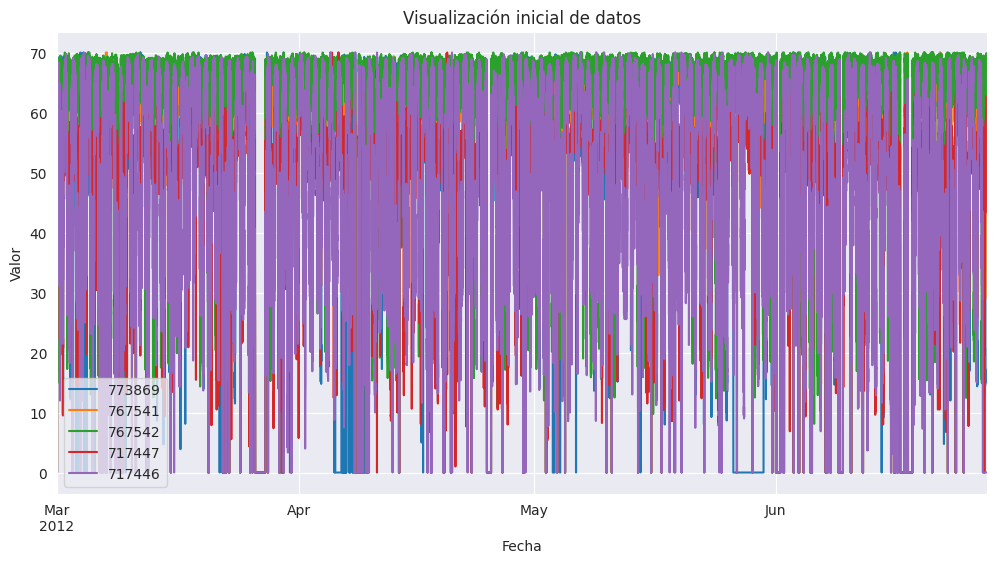

In [3]:
# Verificación de datos
def explore_data(df):
    print(df.info())
    print(df.describe())
    df.iloc[:, :5].plot(figsize=(12,6))  # Graficar las primeras 5 columnas
    plt.title("Visualización inicial de datos")
    plt.xlabel("Fecha")
    plt.ylabel("Valor")
    plt.show()

explore_data(df)

## Static preprocessing (not dependent on the values of train/test)

In [4]:
df.replace(0, np.nan, inplace=True)
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek  # Monday=0, Sunday=6

df

,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,...,774204,769806,717590,717592,717595,772168,718141,769373,hour,day_of_week
2012-03-01 00:00:00,64.375000,67.625000,67.125000,61.500000,66.875000,68.750000,65.125000,67.125000,59.625000,62.750000,...,64.500000,66.428571,66.875000,59.375000,69.000000,59.250000,69.000000,61.875000,0,3
2012-03-01 00:05:00,62.666667,68.555556,65.444444,62.444444,64.444444,68.111111,65.000000,65.000000,57.444444,63.333333,...,66.666667,58.555556,62.000000,61.111111,64.444444,55.888889,68.444444,62.875000,0,3
2012-03-01 00:10:00,64.000000,63.750000,60.000000,59.000000,66.500000,66.250000,64.500000,64.250000,63.875000,65.375000,...,56.500000,59.250000,68.125000,62.500000,65.625000,61.375000,69.857143,62.000000,0,3
2012-03-01 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3
2012-03-01 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-06-27 23:35:00,65.000000,65.888889,68.555556,61.666667,NaN,54.555556,62.444444,63.333333,59.222222,65.333333,...,65.111111,55.666667,66.333333,62.444444,66.777778,64.888889,69.666667,62.333333,23,2
2012-06-27 23:40:00,61.375000,65.625000,66.500000,62.750000,NaN,50.500000,62.000000,67.000000,65.250000,67.125000,...,60.125000,60.500000,67.250000,59.375000,66.000000,61.250000,69.000000,62.000000,23,2
2012-06-27 23:45:00,67.000000,59.666667,69.555556,61.000000,NaN,44.777778,64.222222,63.777778,59.777778,57.666667,...,64.333333,57.000000,66.000000,62.666667,68.666667,63.333333,67.444444,61.222222,23,2
2012-06-27 23:50:00,66.750000,62.250000,66.000000,59.625000,NaN,53.000000,64.285714,64.125000,60.875000,66.250000,...,61.625000,60.500000,65.625000,66.375000,69.500000,63.000000,67.875000,63.500000,23,2


In [5]:
train_size = int(len(df) * 0.8)
# Split the data into train and test sets
train, test = df[:train_size], df[train_size:]

## Dynamic processing (Requires using only the training set to not bias the result)

In [6]:
# Preprocesamiento
#Imputar valores faltantes con interpolación temporal y relleno
hourly_avg = train.groupby(['day_of_week', 'hour']).mean()
hourly_avg

773869     767541     767542     717447     717446  \
day_of_week hour                                                          
0           0     65.372142  65.582711  67.026375  61.933664  66.845904   
            1     64.184350  65.066483  66.898588  61.279935  66.746045   
            2     63.099865  64.701590  66.426796  59.671958  65.872998   
            3     61.682140  62.887922  65.911503  56.811953  64.939726   
            4     62.677072  61.451087  66.233735  57.403617  65.314885   
...                     ...        ...        ...        ...        ...   
6           19    67.717291  66.261680  68.238505  53.510851  54.707517   
            20    67.132675  65.256526  68.245183  54.881963  49.514388   
            21    66.792419  65.082302  67.807615  55.336451  51.047687   
            22    66.523939  65.912133  67.337384  57.697487  59.134204   
            23    66.193221  65.364006  67.430980  61.347200  63.694461   

                     717445     773062     767620     737529     717816  ...  \
day_of_week hour                                                         ...   
0           0     57.290435  65.946352  65.214977  63.111347  67.680681  ...   
            1     56.378231  65.599927  64.527178  61.568929  65.906409  ...   
            2     56.188647  64.952719  64.742376  60.074367  64.939970  ...   
            3     55.557107  64.074850  63.208346  57.713434  65.160905  ...   
            4     58.004206  64.430640  61.524432  59.804074  66.672030  ...   
...                     ...        ...        ...        ...        ...  ...   
6           19    54.343727  60.146712  64.419447  65.405879  65.988176  ...   
            20    55.068833  61.122627  64.589785  64.294662  67.028252  ...   
            21    55.907691  60.743948  64.260628  63.510779  66.774420  ...   
            22    56.554175  63.658336  65.114884  63.850973  67.532118  ...   
            23    58.008605  64.471940  64.910464  63.582156  67.518509  ...   

                     772167     769372     774204     769806     717590  \
day_of_week hour                                                          
0           0     46.432885  67.770000  63.759973  63.882250  66.541633   
            1     43.385520  67.122371  61.286285  62.481787  64.767516   
            2     40.884015  65.915031  59.130547  61.050595  62.778188   
            3     37.557537  63.841283  54.076306  60.914970  59.616113   
            4     40.157977  64.981542  55.315909  62.052239  61.421265   
...                     ...        ...        ...        ...        ...   
6           19    46.085239  68.275847  65.603684  66.804259  68.313388   
            20    47.286555  68.082110  64.958171  65.755571  67.976784   
            21    48.773162  67.763905  64.795723  65.488362  67.884297   
            22    45.684594  68.027089  64.654861  65.148953  67.824411   
            23    47.306765  67.886836  64.251895  64.250351  67.329093   

                     717592     717595     772168     718141     769373  
day_of_week hour                                                         
0           0     63.944489  67.166536  64.833482  67.519831  62.550502  
            1     63.615685  66.649349  62.694998  66.785191  61.234024  
            2     62.978199  65.632995  63.065527  65.696792  60.118931  
            3     61.354539  65.024038  63.508682  62.252417  60.974562  
            4     60.521514  64.661736  65.252054  62.693329  62.548942  
...                     ...        ...        ...        ...        ...  
6           19    65.019767  68.877315  63.712479  67.077424  58.616336  
            20    64.015738  68.103100  63.309928  66.231157  59.210505  
            21    64.115838  67.945187  64.040228  64.824641  60.115660  
            22    64.124170  67.480371  65.569205  66.478210  57.517292  
            23    64.057414  67.381154  65.389799  67.638864  60.001818  

[168 rows x 207 columns]

<Axes: >

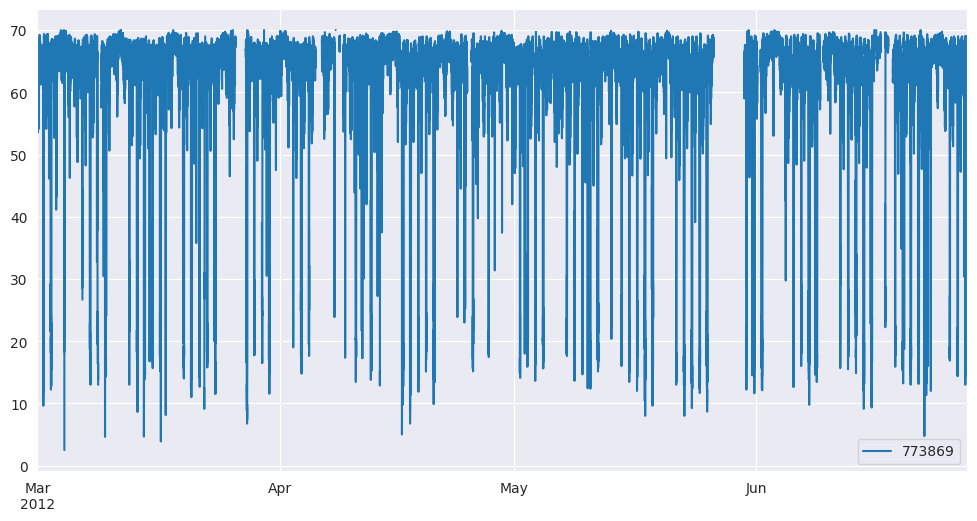

In [7]:
df[["773869"]].plot(figsize=(12,6))

### Use the average of that hour of that day of the week (of the training set) to fill the nulls of both sets

In [8]:
sensor_columns = [col for col in df.columns if col not in ['hour', 'day_of_week']]


In [9]:
train = train.copy()
    
# Iterate through each row
def fill_df(df_to_fill):
    for idx, row in df_to_fill.iterrows():
        hour = idx.hour
        day_of_week = idx.dayofweek
        
        # Iterate through each sensor column
        for col in sensor_columns:
            # Check if the value is missing
            if pd.isna(row[col]):
                # Replace with the average for that day of week and hour
                avg_value = hourly_avg.loc[(day_of_week, hour), col]
                df_to_fill.at[idx, col] = avg_value

fill_df(train)
fill_df(test)

print(train.isnull().sum())
print(test.isnull().sum())

773869         0
767541         0
767542         0
717447         0
717446         0
              ..
772168         0
718141         0
769373         0
hour           0
day_of_week    0
Length: 209, dtype: int64
773869         0
767541         0
767542         0
717447         0
717446         0
              ..
772168         0
718141         0
769373         0
hour           0
day_of_week    0
Length: 209, dtype: int64


<Axes: >

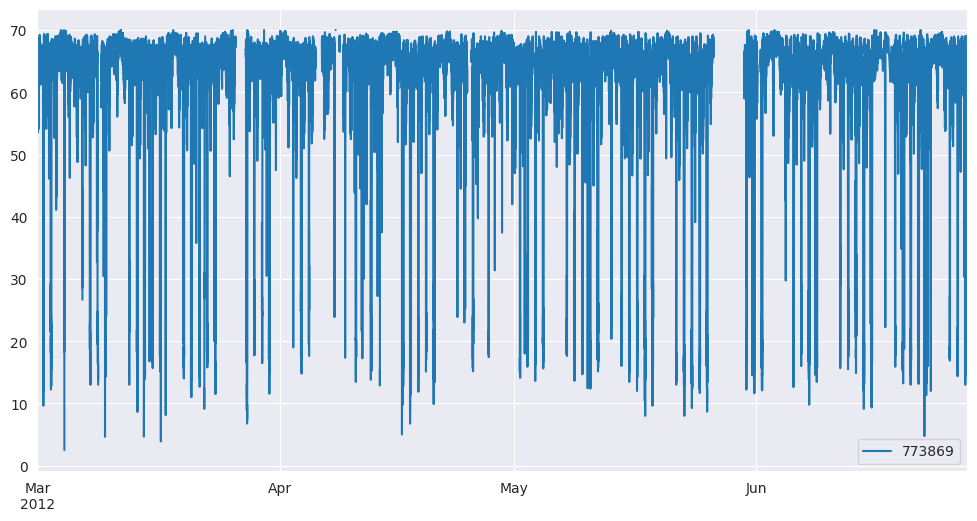

In [10]:
df[["773869"]].plot(figsize=(12,6))

<Axes: >

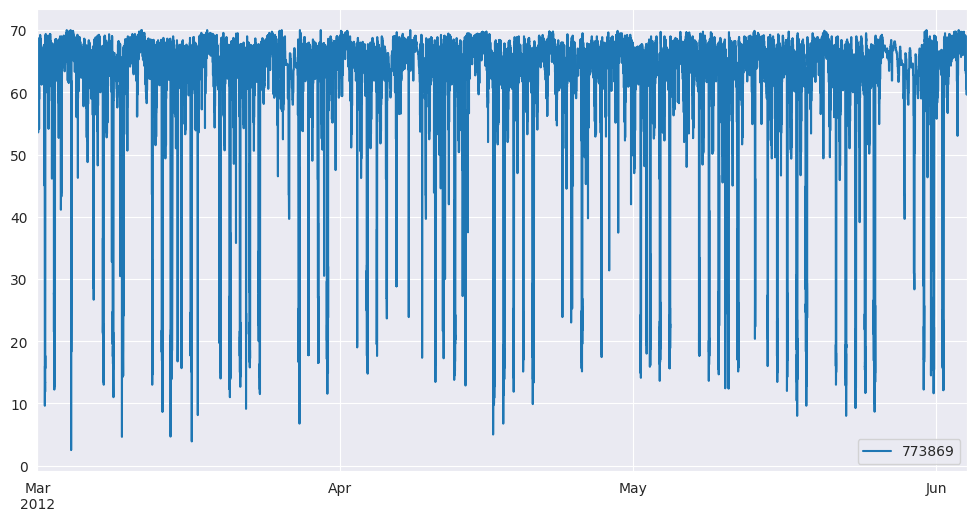

In [11]:
train[["773869"]].plot(figsize=(12,6))

## Use transformations

In [12]:
from scipy import stats
from scipy.stats import shapiro

In [13]:
data = train.iloc[:, 1]
data

2012-03-01 00:00:00    67.625000
2012-03-01 00:05:00    68.555556
2012-03-01 00:10:00    63.750000
2012-03-01 00:15:00    65.283144
2012-03-01 00:20:00    65.283144
                         ...    
2012-06-04 04:20:00    58.250000
2012-06-04 04:25:00    63.777778
2012-06-04 04:30:00    56.750000
2012-06-04 04:35:00    59.375000
2012-06-04 04:40:00    61.222222
Name: 767541, Length: 27417, dtype: float64

--------------------------------------------------
For column 773869
Shapiro-Wilk p-value (as is transformation): 2.2155114703369614e-124
Shapiro-Wilk p-value (best lambda transformation): 3.4166854348088956e-86
Shapiro-Wilk p-value (log): 1.369444791566861e-129
Best lambda: 6.321659262969889


/home/fran/.virtualenvs/traffic-forecasting/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 27417.
  res = hypotest_fun_out(*samples, **kwds)


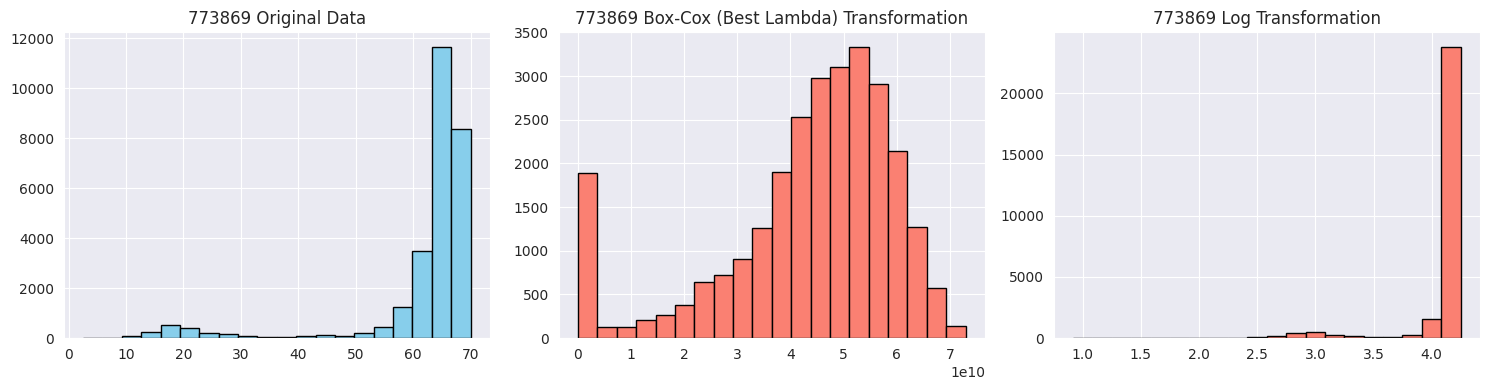

--------------------------------------------------
For column 767541
Shapiro-Wilk p-value (as is transformation): 1.0071906942598839e-108
Shapiro-Wilk p-value (best lambda transformation): 1.9996144109698733e-31
Shapiro-Wilk p-value (log): 1.7165204689368533e-119
Best lambda: 12.29385087116248


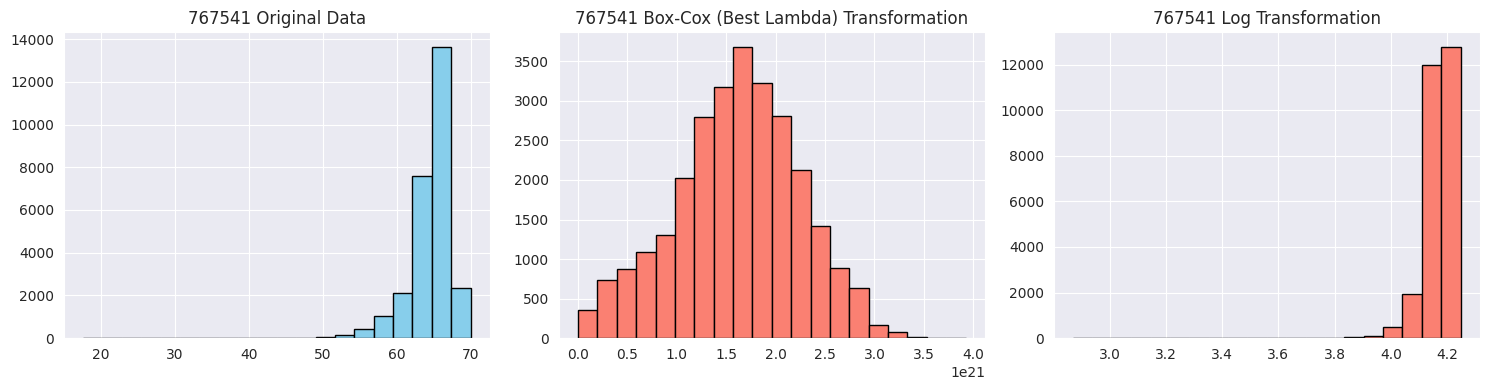

--------------------------------------------------
For column 767542
Shapiro-Wilk p-value (as is transformation): 8.812834903262398e-129
Shapiro-Wilk p-value (best lambda transformation): 2.1389122756770428e-91
Shapiro-Wilk p-value (log): 4.133107509762733e-132
Best lambda: 9.450419203462914


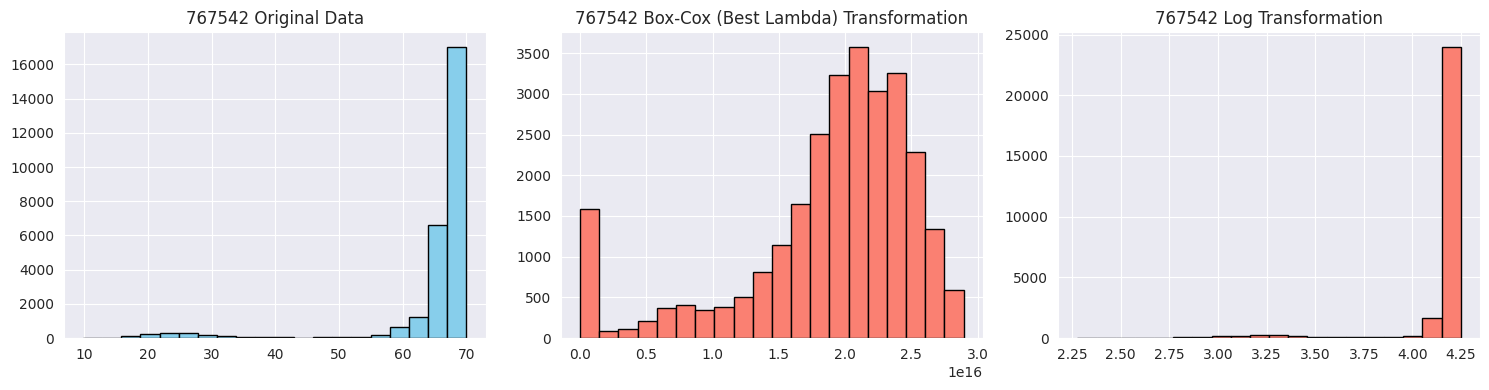

--------------------------------------------------
For column 717447
Shapiro-Wilk p-value (as is transformation): 1.0027254997465898e-102
Shapiro-Wilk p-value (best lambda transformation): 1.213921722925653e-52
Shapiro-Wilk p-value (log): 1.757356566845904e-119
Best lambda: 3.70116233458371


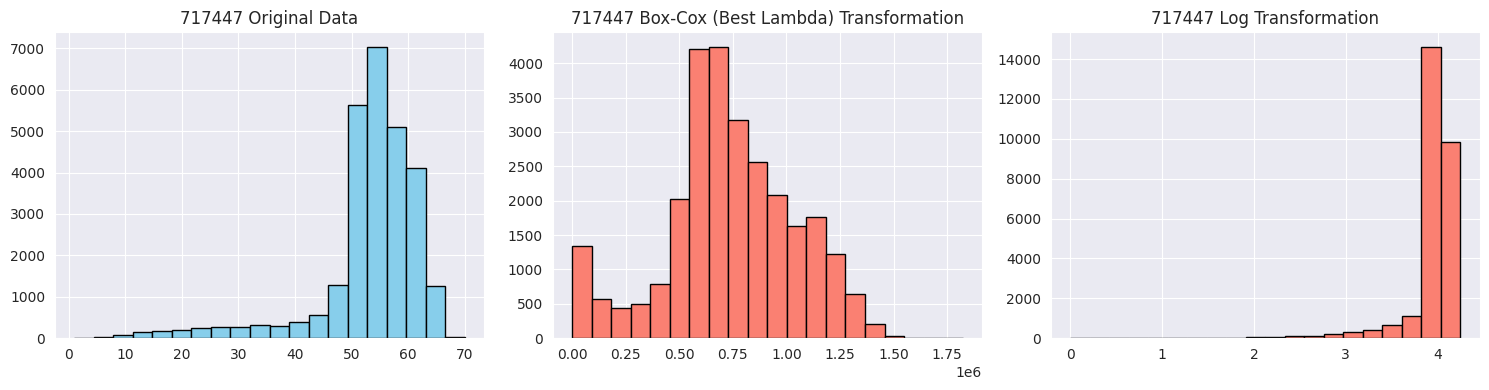

--------------------------------------------------
For column 717446
Shapiro-Wilk p-value (as is transformation): 2.3699751870855786e-82
Shapiro-Wilk p-value (best lambda transformation): 3.174747351837003e-83
Shapiro-Wilk p-value (log): 1.87958060340985e-89
Best lambda: 1.3016506427253993


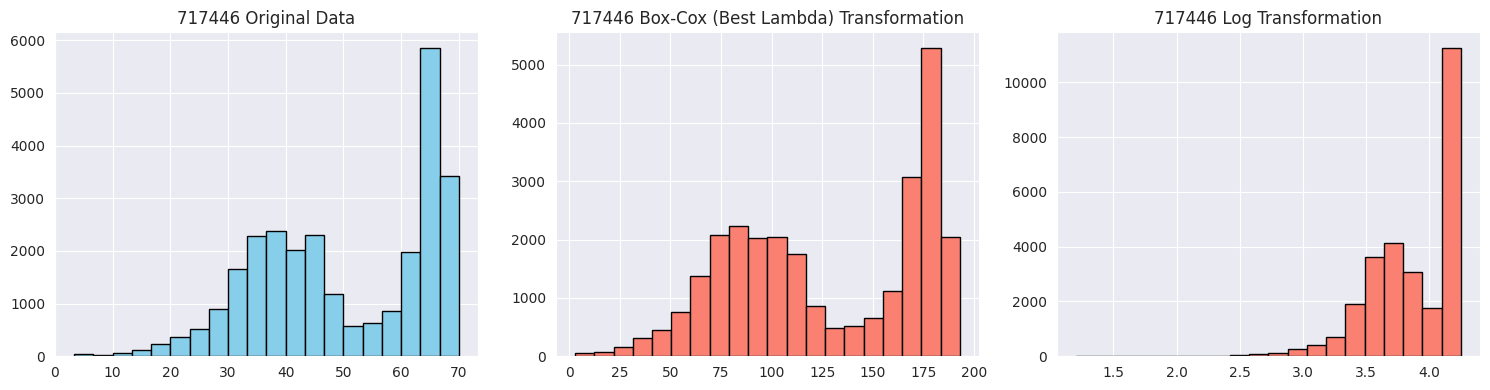

--------------------------------------------------
For column 717445
Shapiro-Wilk p-value (as is transformation): 3.576655860079101e-93
Shapiro-Wilk p-value (best lambda transformation): 5.0000854550310654e-46
Shapiro-Wilk p-value (log): 2.5022619778330794e-113
Best lambda: 3.199859104797124
--------------------------------------------------
For column 773062
Shapiro-Wilk p-value (as is transformation): 3.43011952011134e-110
Shapiro-Wilk p-value (best lambda transformation): 5.318619748555616e-80
Shapiro-Wilk p-value (log): 3.441612643386176e-116
Best lambda: 5.4707034127751815
--------------------------------------------------
For column 767620
Shapiro-Wilk p-value (as is transformation): 2.324449212909538e-78
Shapiro-Wilk p-value (best lambda transformation): 3.167772492111028e-08
Shapiro-Wilk p-value (log): 1.204024778882136e-94
Best lambda: 7.6475632886165235
--------------------------------------------------
For column 737529
Shapiro-Wilk p-value (as is transformation): 2.01739796

{'773869': 6.321659262969889,
 '767541': 12.29385087116248,
 '767542': 9.450419203462914,
 '717447': 3.70116233458371,
 '717446': 1.3016506427253993,
 '717445': 3.199859104797124,
 '773062': 5.4707034127751815,
 '767620': 7.6475632886165235,
 '737529': 5.677444521013808,
 '717816': 3.0370940361250645,
 '765604': 6.037046966075377,
 '767471': 7.701175058539847,
 '716339': 0.4007550913228705,
 '773906': 8.90657100222269,
 '765273': 3.774683128324651,
 '716331': 1.1792446723663979,
 '771667': 1.3502788044703808,
 '716337': 5.404905030589096,
 '769953': 4.282229182047655,
 '769402': 6.222394079581528,
 '769403': 9.050489362603123,
 '769819': 6.142706420190436,
 '769405': 4.691970811067396,
 '716941': 3.5148278319374886,
 '717578': 9.778271905813982,
 '716960': 3.9646635334635922,
 '717804': 3.165794531069099,
 '767572': 9.260867636586674,
 '767573': 10.36222823531046,
 '773012': 2.6974734463400942,
 '773013': 4.771013191743886,
 '764424': 14.173769345931074,
 '769388': 8.979183641264106,
 

In [14]:
# 1. Perform Box-Cox transformation "as is"
lambdas = {}
for i, col in enumerate(sensor_columns):    
    # Perform Box-Cox transformation with the best lambda
    data = train[col].values
    
    transformed_best_lambda, best_lambda = stats.boxcox(data)
    lambdas[col] = best_lambda
    
    # Function to calculate the Shapiro-Wilk p-value for normality
    def normality_test(data):
        stat, p_value = shapiro(data)
        return p_value
    
    # Shapiro-Wilk test p-values for normality
    p_value_as_is = normality_test(data)
    p_value_best_lambda = normality_test(transformed_best_lambda)
    p_value_log = normality_test(np.log(data))
    
    # Results
    print("-"*50 + f"\nFor column {col}")
    print(f"Shapiro-Wilk p-value (as is transformation): {p_value_as_is}")
    print(f"Shapiro-Wilk p-value (best lambda transformation): {p_value_best_lambda}")
    print(f"Shapiro-Wilk p-value (log): {p_value_log}")
    print(f"Best lambda: {best_lambda}")
    
    if i < 5:
        # Plot the original and transformed data
        fig, axs = plt.subplots(1, 3, figsize=(15, 4))
        axs[0].hist(data, bins=20, color='skyblue', edgecolor='black')
        axs[0].set_title(f'{col} Original Data')
        
        axs[1].hist(transformed_best_lambda, bins=20, color='salmon', edgecolor='black')
        axs[1].set_title(f'{col} Box-Cox (Best Lambda) Transformation')
        
        axs[2].hist(np.log(data), bins=20, color='salmon', edgecolor='black')
        axs[2].set_title(f'{col} Log Transformation')
        
        plt.tight_layout()
        plt.show()
lambdas

In [15]:
sensor_columns

['773869',
 '767541',
 '767542',
 '717447',
 '717446',
 '717445',
 '773062',
 '767620',
 '737529',
 '717816',
 '765604',
 '767471',
 '716339',
 '773906',
 '765273',
 '716331',
 '771667',
 '716337',
 '769953',
 '769402',
 '769403',
 '769819',
 '769405',
 '716941',
 '717578',
 '716960',
 '717804',
 '767572',
 '767573',
 '773012',
 '773013',
 '764424',
 '769388',
 '716328',
 '717819',
 '769941',
 '760987',
 '718204',
 '718045',
 '769418',
 '768066',
 '772140',
 '773927',
 '760024',
 '774012',
 '774011',
 '767609',
 '769359',
 '760650',
 '716956',
 '769831',
 '761604',
 '717495',
 '716554',
 '773953',
 '767470',
 '716955',
 '764949',
 '773954',
 '767366',
 '769444',
 '773939',
 '774067',
 '769443',
 '767750',
 '767751',
 '767610',
 '773880',
 '764766',
 '717497',
 '717490',
 '717491',
 '717492',
 '717493',
 '765176',
 '717498',
 '717499',
 '765171',
 '718064',
 '718066',
 '765164',
 '769431',
 '769430',
 '717610',
 '767053',
 '767621',
 '772596',
 '772597',
 '767350',
 '767351',
 '716571',

In [16]:
std_scaler = StandardScaler()
std_scaler.fit(train[sensor_columns])

StandardScaler()

In [17]:
transformation = "std"

train_tf = train.copy()
test_tf = test.copy()

if transformation == "boxcox":
    for col in sensor_columns:
        train_tf[col] = stats.boxcox(train[col], lmbda=lambdas[col])
        test_tf[col] = stats.boxcox(test[col], lmbda=lambdas[col])
elif transformation == "std":
    train_tf[sensor_columns] = std_scaler.transform(train[sensor_columns])
    test_tf[sensor_columns] = std_scaler.transform(test[sensor_columns])

train_tf

,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,...,774204,769806,717590,717592,717595,772168,718141,769373,hour,day_of_week
2012-03-01 00:00:00,0.217586,0.943273,0.245590,0.904404,1.133957,1.341417,0.593326,1.390853,-0.116745,0.306734,...,0.502987,0.601830,0.244778,-0.923473,0.629964,0.072017,0.559996,0.405138,0,3
2012-03-01 00:05:00,0.069654,1.224740,0.072564,1.005865,0.969508,1.279447,0.581974,0.627775,-0.375672,0.337469,...,0.664885,-1.207397,-0.467107,-0.432857,-0.716443,-0.337857,0.499692,0.466763,0,3
2012-03-01 00:10:00,0.185113,-0.228806,-0.487982,0.635829,1.108585,1.098925,0.536568,0.358453,0.387916,0.445044,...,-0.094788,-1.047813,0.427313,-0.040365,-0.367527,0.331151,0.653035,0.412841,0,3
2012-03-01 00:15:00,0.067740,0.234928,0.107302,0.918512,1.013454,0.090025,0.550249,0.368581,-0.258264,0.352956,...,0.240504,-1.143599,-0.082542,-0.285207,-0.226320,0.482599,0.436589,0.363913,0,3
2012-03-01 00:20:00,0.067740,0.234928,0.107302,0.918512,1.013454,0.090025,0.550249,0.368581,-0.258264,0.352956,...,0.240504,-1.143599,-0.082542,-0.285207,-0.226320,0.482599,0.436589,0.363913,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-06-04 04:20:00,0.412423,-1.892401,-0.050413,0.273253,0.922522,-0.246902,0.933871,-1.616574,0.595717,0.538191,...,-0.160169,-1.076538,-0.722656,-1.418013,-0.626136,0.331151,-0.199826,0.559200,4,0
2012-06-04 04:25:00,0.146627,-0.220404,0.289919,0.241919,1.127379,-0.541933,0.662696,-0.449513,0.442340,0.576768,...,-0.273290,-0.973948,-0.499558,-0.809650,-0.289534,0.569962,0.113751,0.542938,4,0
2012-06-04 04:30:00,0.066046,-2.346109,0.013935,0.555256,1.007096,-0.295400,0.415486,0.672662,0.046528,0.590881,...,-0.393675,-0.042434,-0.248066,1.372608,-0.293638,0.940880,-0.661147,0.551497,4,0
2012-06-04 04:35:00,0.347477,-1.552120,0.374287,0.394111,0.947895,0.128960,0.309538,-0.449513,0.076213,0.568300,...,0.166739,-0.214784,-0.175052,-1.347365,0.149691,0.727475,-0.484759,0.466763,4,0


<Axes: >

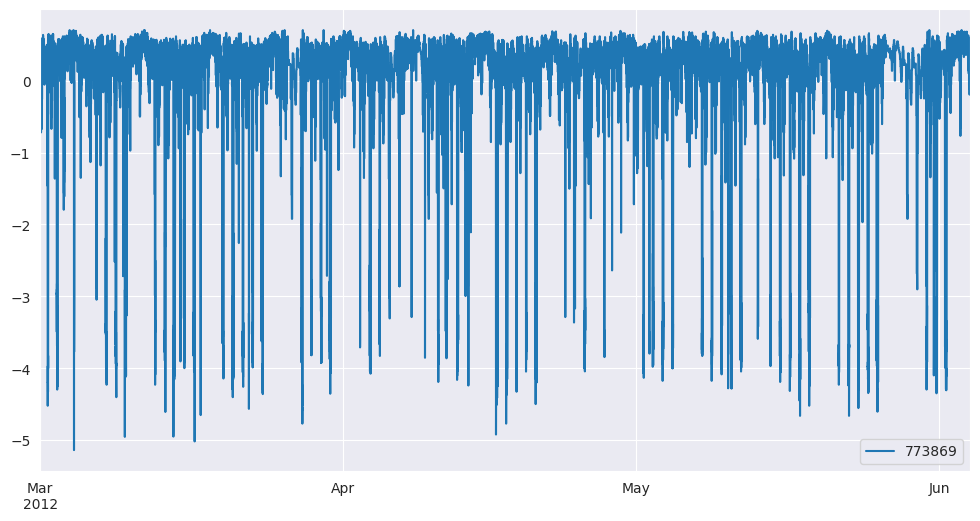

In [18]:
train_tf[["773869"]].plot(figsize=(12,6))

## Train model

In [19]:
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.api import VAR
from pmdarima import auto_arima, plot_acf, plot_pacf
from scipy.special import inv_boxcox
from tqdm import tqdm 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [20]:
longest = 30//5
max_periods = 7*24*60//5
n_periods = min(test.shape[0] - longest, max_periods)
max_cols = 5

In [21]:
from pmdarima.arima.utils import ndiffs
from pmdarima.arima.utils import nsdiffs


Estimated period (with ACF) 12
0 0


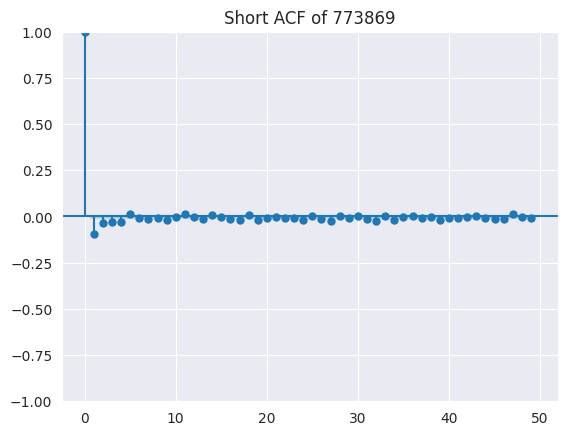

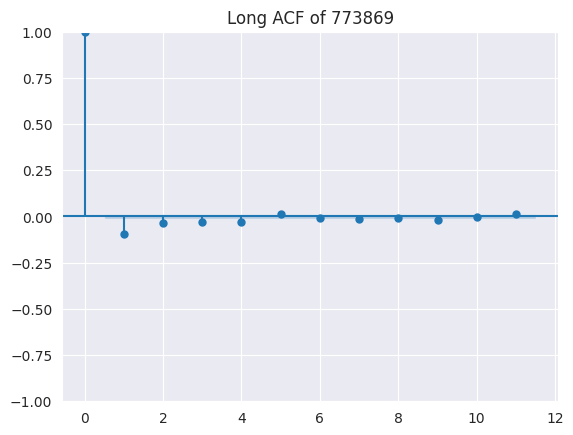

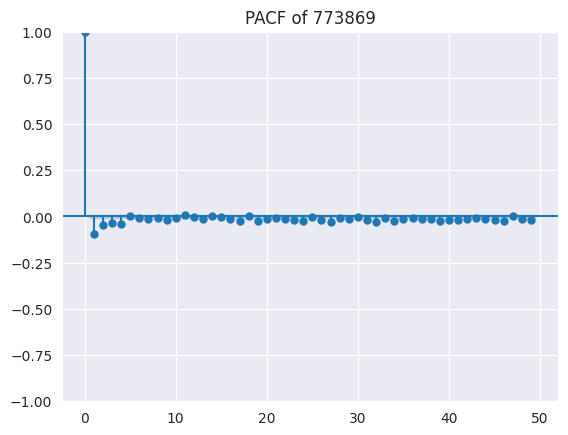

0 0


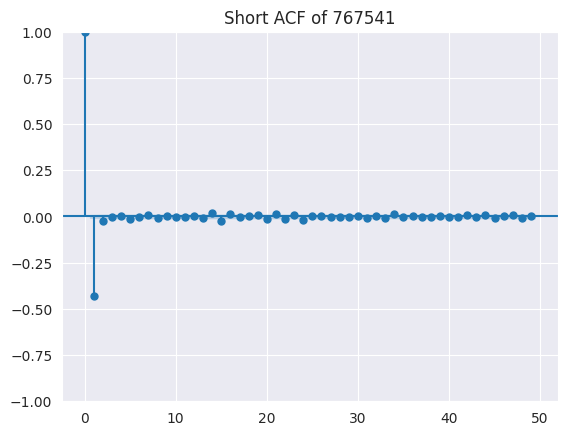

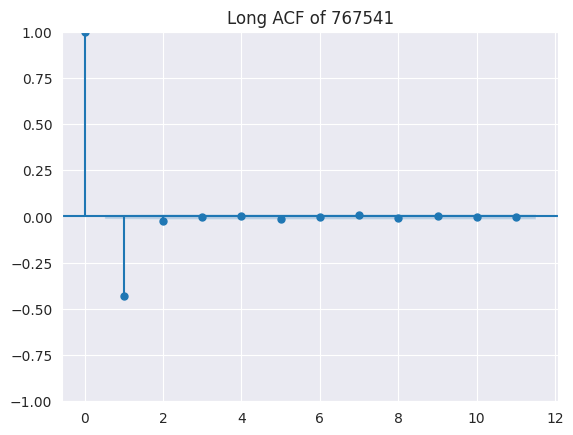

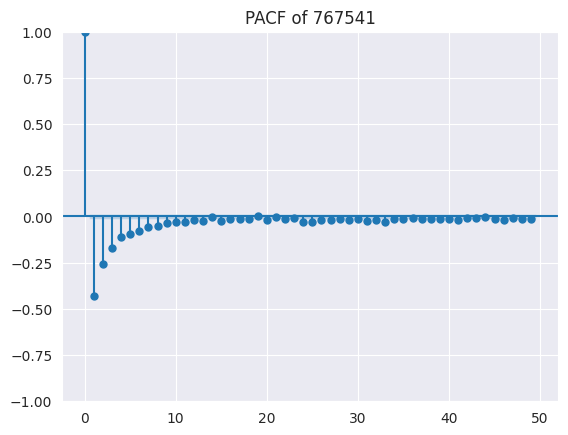

0 0


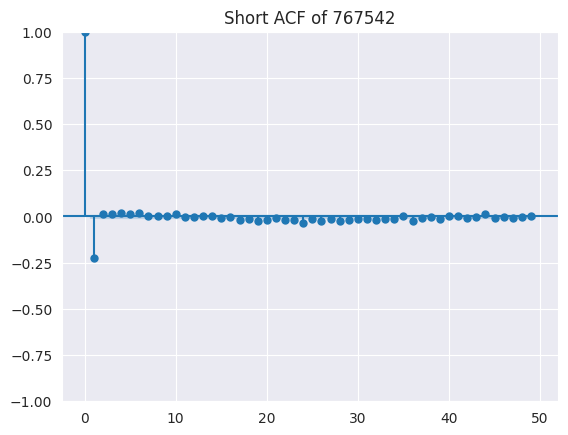

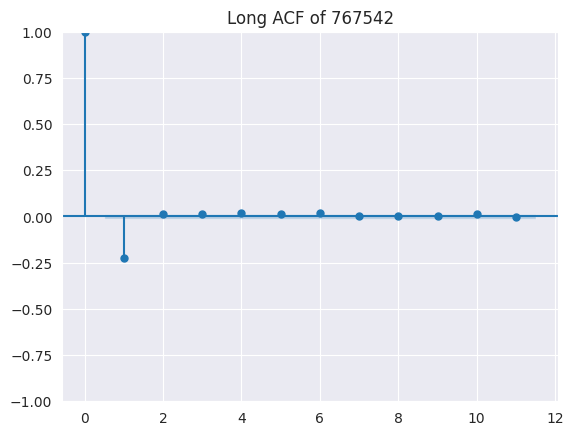

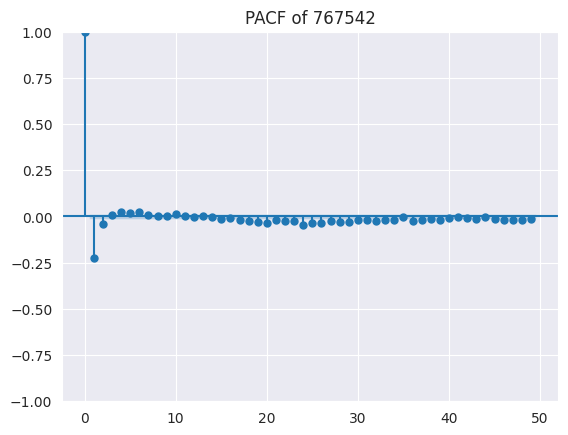

0 0


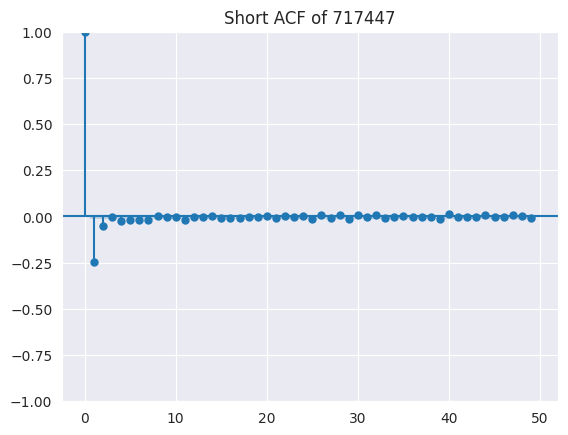

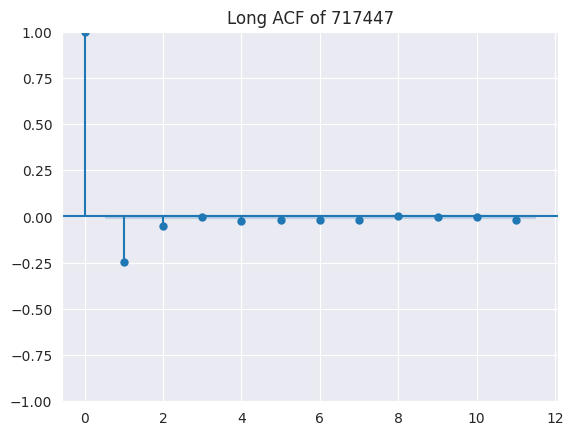

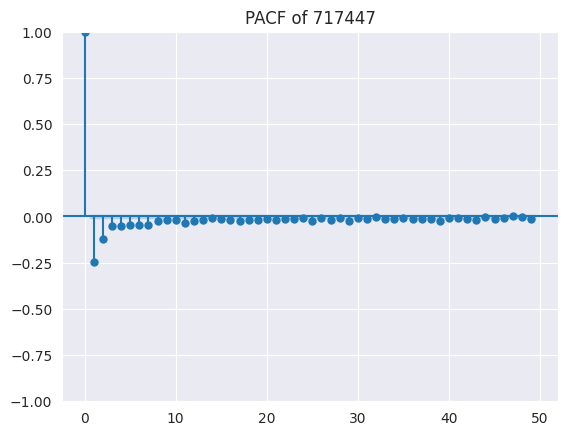

0 0


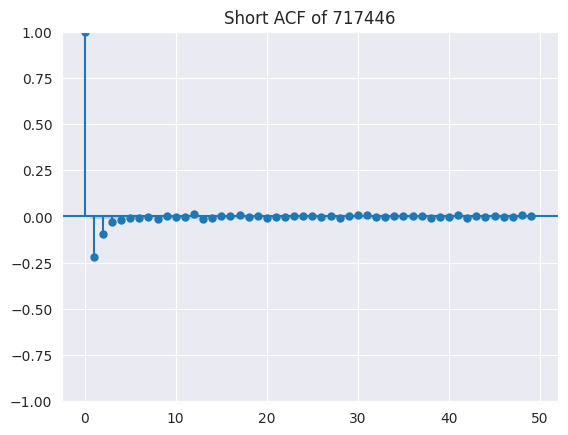

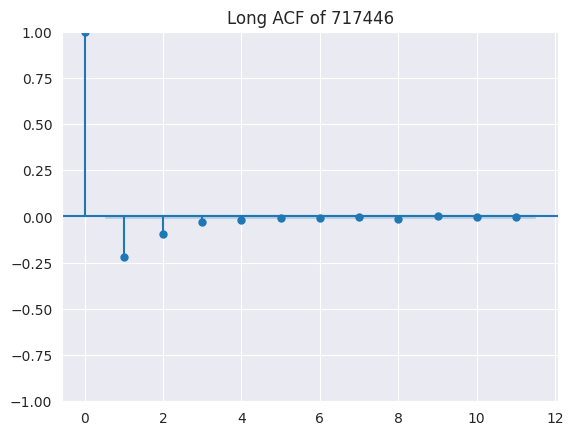

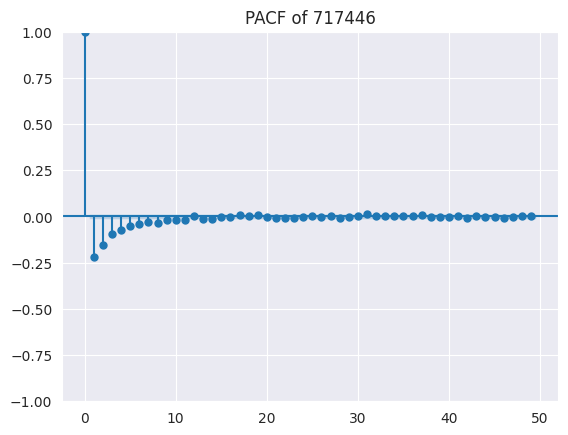

In [22]:
period = longest * 2
print("Estimated period (with ACF)", period)
    
for col in sensor_columns[:max_cols]:
    y = np.diff(train_tf[col].values)
    # y = train_tf[col].values
    
    # Estimate the number of differences using an ADF test:
    n_adf = ndiffs(y, test='adf')  # -> 0
    
    # Or a KPSS test (auto_arima default):
    n_kpss = ndiffs(y, test='kpss')  # -> 0
    print(n_adf, n_kpss)
    
    # Or a PP test:
    n_pp = ndiffs(y, test='pp')  # -> 0
    assert n_adf == n_kpss == n_pp == 0
    
    
    plot_acf(y, alpha=0.05, lags=np.arange(50), title=f"Short ACF of {col}")
    plot_acf(y, alpha=0.05, lags=np.arange(longest * 2), title=f"Long ACF of {col}")
    plot_pacf(y, alpha=0.05, lags=np.arange(50), title=f"PACF of {col}")
    

In [29]:
train_tf = train_tf.asfreq('5min')  # Explicitly set frequency
# seasonality = 24*60//5
# print("Seasonality: ", seasonality)

max_p = 1
max_q = 0
mse_results = {'lag': [lag+1 for lag in range(longest)]}
mse_results.update({f'mse_{col}': [] for col in sensor_columns[:max_cols]})

step_sz = len(test_tf)//n_periods

print(mse_results)

for col_idx, col in enumerate(sensor_columns[:max_cols]):
    all_predictions = [[] for _ in range(longest)]
    scaler = StandardScaler()
    scaler.fit(train[col].values.reshape(-1, 1))
    
    # Automatically find the best parameters
    model = auto_arima(train_tf[col], 
                      # seasonal=True,  # Enable seasonal components
                      # m=seasonality,    # Set seasonal period (adjust based on your data)
                      start_p=max_p, start_q=max_q, max_p=max_p, max_q=max_q, d=1,
                      # start_P=0, start_Q=0, max_P=2, max_Q=2, D=1,        # Seasonal 
                      trace=True,      # Print model evaluation results
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True,
                      # n_jobs=8
                    )   # Use the stepwise algorithm for faster results
    
    print(f"Best SARIMA parameters for {col}: {model.order} {model.seasonal_order}")

    # Rolling forecast: forecast one step ahead and update the model with the actual observation
    for t in tqdm(range(n_periods), desc="Rolling Forecasting"):
        # Forecast the next time step
        forecast = model.predict(n_periods=longest)        
        if isinstance(forecast, pd.Series):
            forecast = forecast.values
        if isinstance(forecast, pd.DataFrame):
            forecast = forecast.values        
        
        forecast = np.array(forecast, dtype=float).flatten()
        
        # Append each forecast value to the corresponding prediction list
        for k in range(longest):
            all_predictions[k].append(float(forecast[k]))
        
        if t < n_periods - 1:
            model.update(test_tf[col].iloc[t*step_sz:(t+1)*step_sz])    
    
    for k in range(longest):
        all_predictions[k] = np.array(all_predictions[k])    
    
    # Process each forecast horizon
    for k in tqdm(range(longest), desc="Processing loss"):
        # Get the forecasts for this horizon
        if transformation == "boxcox":
            inverted_forecast = inv_boxcox(all_predictions[k], lambdas[col])
        else:
            inverted_forecast = scaler.inverse_transform(all_predictions[k].reshape(-1, 1)).flatten()
        
        # Calculate MSE against actual values (offset by k)
        idx = k + step_sz*np.arange(start=0, stop=n_periods)
        # print(idx.shape)
        # print(inverted_forecast.shape)
        mse = mean_squared_error(test[col][idx], inverted_forecast)
        print(f"For column {col} and lag {k}: MSE={mse}")
        
        mse_results[f'mse_{col}'].append(mse)
    
# Create a DataFrame from the results
mse_df = pd.DataFrame(mse_results)
    
mse_df

{'lag': [1, 2, 3, 4, 5, 6], 'mse_773869': [], 'mse_767541': [], 'mse_767542': [], 'mse_717447': [], 'mse_717446': []}
Performing stepwise search to minimize aic
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17942.202, Time=1.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18194.439, Time=3.53 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18192.439, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=17940.202, Time=0.41 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 5.890 seconds
Best SARIMA parameters for 773869: (1, 1, 0) (0, 0, 0, 0)


Processing loss: 100%|██████████| 6/6 [00:00<00:00, 1422.44it/s]


For column 773869 and lag 0: MSE=13.334363451876897
For column 773869 and lag 1: MSE=26.813688862580783
For column 773869 and lag 2: MSE=36.19836238659643
For column 773869 and lag 3: MSE=48.558185083083934
For column 773869 and lag 4: MSE=62.76564136370432
For column 773869 and lag 5: MSE=70.96190150673243
Performing stepwise search to minimize aic
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=63716.727, Time=1.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=69376.898, Time=3.58 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=69374.898, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=63714.727, Time=0.34 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 5.682 seconds
Best SARIMA parameters for 767541: (1, 1, 0) (0, 0, 0, 0)


Processing loss: 100%|██████████| 6/6 [00:00<00:00, 1449.31it/s]


For column 767541 and lag 0: MSE=6.077792949192195
For column 767541 and lag 1: MSE=7.766399024715299
For column 767541 and lag 2: MSE=8.941432506409964
For column 767541 and lag 3: MSE=8.582015231779485
For column 767541 and lag 4: MSE=8.51314550842329
For column 767541 and lag 5: MSE=9.856218232105258
Performing stepwise search to minimize aic
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16329.090, Time=1.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17716.595, Time=4.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17714.595, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=16327.090, Time=0.38 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 6.158 seconds
Best SARIMA parameters for 767542: (1, 1, 0) (0, 0, 0, 0)


Processing loss: 100%|██████████| 6/6 [00:00<00:00, 1401.53it/s]


For column 767542 and lag 0: MSE=11.405989786127368
For column 767542 and lag 1: MSE=19.393049964012267
For column 767542 and lag 2: MSE=23.21863999363297
For column 767542 and lag 3: MSE=28.78045964858877
For column 767542 and lag 4: MSE=40.722206520157265
For column 767542 and lag 5: MSE=44.884379149019814
Performing stepwise search to minimize aic
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=33681.665, Time=1.73 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=35383.755, Time=2.94 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=35381.755, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=33679.665, Time=0.38 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 5.331 seconds
Best SARIMA parameters for 717447: (1, 1, 0) (0, 0, 0, 0)


Processing loss: 100%|██████████| 6/6 [00:00<00:00, 1430.61it/s]


For column 717447 and lag 0: MSE=15.748670900059901
For column 717447 and lag 1: MSE=24.26933488527
For column 717447 and lag 2: MSE=29.59471499771822
For column 717447 and lag 3: MSE=37.58758163209505
For column 717447 and lag 4: MSE=40.35644513536413
For column 717447 and lag 5: MSE=42.6152142131392
Performing stepwise search to minimize aic
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19816.920, Time=1.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=21177.152, Time=3.80 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=21175.152, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=19814.920, Time=0.38 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 5.986 seconds
Best SARIMA parameters for 717446: (1, 1, 0) (0, 0, 0, 0)


Processing loss: 100%|██████████| 6/6 [00:00<00:00, 1409.85it/s]

For column 717446 and lag 0: MSE=27.11112447243473
For column 717446 and lag 1: MSE=39.32063199243906
For column 717446 and lag 2: MSE=46.20518720011115
For column 717446 and lag 3: MSE=54.42894862869102
For column 717446 and lag 4: MSE=59.62945022452329
For column 717446 and lag 5: MSE=66.2567821538008


,lag,mse_773869,mse_767541,mse_767542,mse_717447,mse_717446
0,1,13.334363,6.077793,11.405990,15.748671,27.111124
1,2,26.813689,7.766399,19.393050,24.269335,39.320632
2,3,36.198362,8.941433,23.218640,29.594715,46.205187
3,4,48.558185,8.582015,28.780460,37.587582,54.428949
4,5,62.765641,8.513146,40.722207,40.356445,59.629450
5,6,70.961902,9.856218,44.884379,42.615214,66.256782


In [35]:
train_tf = train_tf.asfreq('5min')  # Explicitly set frequency
# seasonality = 24*60//5
# print("Seasonality: ", seasonality)

old_periods = n_periods
old_max_cols = max_cols
max_cols = 2
n_periods = 30
max_p = 3
max_q = 2
mse_results = {'lag': [lag+1 for lag in range(longest)]}
mse_results.update({f'mse_{col}': [] for col in sensor_columns[:max_cols]})

step_sz = len(test_tf)//n_periods

print(mse_results)

for col_idx, col in enumerate(sensor_columns[:max_cols]):
    all_predictions = [[] for _ in range(longest)]
    scaler = StandardScaler()
    scaler.fit(train[col].values.reshape(-1, 1))
    
    # Automatically find the best parameters
    model = auto_arima(train_tf[col], 
                      # seasonal=True,  # Enable seasonal components
                      # m=seasonality,    # Set seasonal period (adjust based on your data)
                      start_p=max_p, start_q=max_q, max_p=max_p, max_q=max_q, d=1,
                      # start_P=0, start_Q=0, max_P=2, max_Q=2, D=1,        # Seasonal 
                      trace=True,      # Print model evaluation results
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True,
                      # n_jobs=8
                    )   # Use the stepwise algorithm for faster results
    
    print(f"Best SARIMA parameters for {col}: {model.order} {model.seasonal_order}")
    test_idx2 = step_sz*np.arange(start=0, stop=n_periods)
    # Rolling forecast: forecast one step ahead and update the model with the actual observation
    for t in tqdm(range(n_periods), desc="Rolling Forecasting"):
        forecast = model.predict(n_periods=longest)        
        if isinstance(forecast, pd.Series):
            forecast = forecast.values
        if isinstance(forecast, pd.DataFrame):
            forecast = forecast.values        
        
        forecast = np.array(forecast, dtype=float).flatten()
        
        # Append each forecast value to the corresponding prediction list
        for k in range(longest):
            all_predictions[k].append(float(forecast[k]))
        
        if t < n_periods - 1:
            model.update(test_tf[col].iloc[t*step_sz:(t+1)*step_sz])    
    
    for k in range(longest):
        all_predictions[k] = np.array(all_predictions[k])    
    
    # Process each forecast horizon
    for k in range(longest):
        # Get the forecasts for this horizon
        if transformation == "boxcox":
            inverted_forecast = inv_boxcox(all_predictions[k], lambdas[col])
        else:
            inverted_forecast = scaler.inverse_transform(all_predictions[k].reshape(-1, 1)).flatten()
        
        # Calculate MSE against actual values (offset by k)
        idx = k + test_idx2
        mse = mean_squared_error(test[col][idx], inverted_forecast)
        print(f"For column {col} and lag {k}: MSE={mse}")
        
        mse_results[f'mse_{col}'].append(mse)
    
# Create a DataFrame from the results
mse_df = pd.DataFrame(mse_results)
n_periods = old_periods
max_cols = old_max_cols
mse_df

{'lag': [1, 2, 3, 4, 5, 6], 'mse_773869': [], 'mse_767541': []}
Performing stepwise search to minimize aic
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=35.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18194.439, Time=2.71 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17942.202, Time=1.36 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17918.066, Time=2.87 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18192.439, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17819.315, Time=9.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=26.68 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=30.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=17868.205, Time=4.23 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=17890.332, Time=2.21 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=17820.051, Time=12.71 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=17817.315, Time=1.62 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=17916.066, Time=0.48 sec
 ARIMA(1,1,0)(0,0,0)[0]             

Processing loss: 100%|██████████| 6/6 [00:00<00:00, 1348.72it/s]


For column 773869 and lag 0: MSE=10.511033189814182
For column 773869 and lag 1: MSE=5.350209193991815
For column 773869 and lag 2: MSE=13.207237743576115
For column 773869 and lag 3: MSE=4.451937682259551
For column 773869 and lag 4: MSE=16.477634676759262
For column 773869 and lag 5: MSE=21.11077849724831
Performing stepwise search to minimize aic
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=59790.498, Time=38.96 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=69376.898, Time=3.71 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=63716.727, Time=1.57 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=60189.871, Time=4.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=69374.898, Time=0.28 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=59840.768, Time=34.68 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=59985.181, Time=13.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=60015.052, Time=8.90 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=7.64 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0] intercept
T

Rolling Forecasting:  73%|███████▎  | 22/30 [04:50<01:45, 13.22s/it]


KeyboardInterrupt: 

In [ ]:
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX

In [ ]:
train_tf = train_tf.asfreq('5min')  # Explicitly set frequency
# seasonality = 24*60//5
# print("Seasonality: ", seasonality)

old_periods = n_periods
old_max_cols = max_cols
max_cols = 5
n_periods = 30
max_p = 2
max_q = 2
mse_results = {'lag': [lag+1 for lag in range(longest)]}
mse_results.update({f'mse_{col}': [] for col in sensor_columns[:max_cols]})
exogenous_cols = [other_col for other_col in sensor_columns[:max_cols] if other_col != col]
step_sz = len(test_tf)//n_periods

print(mse_results)

for col_idx, col in enumerate(sensor_columns[:max_cols]):
    all_predictions = [[] for _ in range(longest)]
    scaler = StandardScaler()
    scaler.fit(train[col].values.reshape(-1, 1))
    
    # Automatically find the best parameters
    exogenous = train_tf[exogenous_cols]
    model = auto_arima(train_tf[col], X=exogenous,
                      # seasonal=True,  # Enable seasonal components
                      # m=seasonality,    # Set seasonal period (adjust based on your data)
                      start_p=2, start_q=1, max_p=max_p, max_q=max_q, d=1,
                      # start_P=0, start_Q=0, max_P=2, max_Q=2, D=1,        # Seasonal 
                      trace=True,      # Print model evaluation results
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True,
                      # n_jobs=8
                    )   # Use the stepwise algorithm for faster results
    
    print(f"Best SARIMA parameters for {col}: {model.order} {model.seasonal_order}")
    test_idx2 = step_sz*np.arange(start=0, stop=n_periods)
    # Rolling forecast: forecast one step ahead and update the model with the actual observation
    for t in tqdm(range(n_periods), desc="Rolling Forecasting"):
        forecast = model.predict(n_periods=longest, X=test_tf[col].iloc[t*step_sz:t*step_sz + longest])        
        if isinstance(forecast, pd.Series):
            forecast = forecast.values
        if isinstance(forecast, pd.DataFrame):
            forecast = forecast.values        
        
        forecast = np.array(forecast, dtype=float).flatten()
        
        # Append each forecast value to the corresponding prediction list
        for k in range(longest):
            all_predictions[k].append(float(forecast[k]))
        
        if t < n_periods - 1:
            model.update(test_tf[col].iloc[t*step_sz:(t+1)*step_sz], X=test_tf[col].iloc[t*step_sz:(t+1)*step_sz])    
    
    for k in range(longest):
        all_predictions[k] = np.array(all_predictions[k])    
    
    # Process each forecast horizon
    for k in range(longest):
        # Get the forecasts for this horizon
        if transformation == "boxcox":
            inverted_forecast = inv_boxcox(all_predictions[k], lambdas[col])
        else:
            inverted_forecast = scaler.inverse_transform(all_predictions[k].reshape(-1, 1)).flatten()
        
        # Calculate MSE against actual values (offset by k)
        idx = k + test_idx2
        mse = mean_squared_error(test[col][idx], inverted_forecast)
        print(f"For column {col} and lag {k}: MSE={mse}")
        
        mse_results[f'mse_{col}'].append(mse)
    
# Create a DataFrame from the results
mse_df = pd.DataFrame(mse_results)
n_periods = old_periods
max_cols = old_max_cols
mse_df

{'lag': [1, 2, 3, 4, 5, 6], 'mse_773869': [], 'mse_767541': [], 'mse_767542': [], 'mse_717447': [], 'mse_717446': []}
Performing stepwise search to minimize aic
